In [1]:
from scalp_utils import *
import joblib
from IPython.display import clear_output
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
plt.style.use('dark_background')
pd.options.display.precision = 10

In [5]:
# import importlib
# importlib.reload()

In [2]:
# # Thesis model
# model = joblib.load('lgbm_fast.pkl')
# features_names = pd.read_csv('features_fast.csv').columns.tolist()

# Old and good model
# model = joblib.load('forest_full.pkl')
# features_names = pd.read_csv('features_forest.csv').columns.tolist()

# no leak
# model = joblib.load('lgbm_full_no_leak.pkl')
# features_names = pd.read_csv('features_lgbm_no_leak.csv').columns.tolist()

# only AH
# model_AH = joblib.load('lgbm_AH_only_7.pkl')
# features_names_AH = pd.read_csv('features_AH_only_7.csv').columns.tolist()


In [ ]:
# include 38,400,423 raw norm
y_all_bi = get_all_y_multi_channel(subjects=['38', '396', '398', '400', '402', '406', '415', '416', '423'])
clear_output()
feat_avg = get_all_feat_avg_channels()
feat_all_eog2 = get_all_feat_eog('2')
clear_output()
feat_avg.reset_index(inplace=True, drop=True)
feat_all_eog2.reset_index(inplace=True, drop=True)
feat_eog2_avg = pd.concat([feat_avg, feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
cls, pred_details = plt_cls(feat_eog2_avg, y_all_bi)

In [ ]:
feat_all_eog1 = joblib.load('feat_all_eog1.pkl')
feat_all_eog2 = joblib.load('feat_all_eog2.pkl')
feat_avg = joblib.load('feat_avg.pkl')
y_all_bi = joblib.load('y_all_bi.pkl')

In [ ]:
feat_avg.reset_index(inplace=True, drop=True)
feat_all_eog1.reset_index(inplace=True, drop=True)
feat_all_eog2.reset_index(inplace=True, drop=True)
feat_eog2_avg = pd.concat([feat_avg, feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_eog12_avg = pd.concat([feat_avg, feat_all_eog1.iloc[:, 2:].add_suffix('_1'), feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_eog1_avg = pd.concat([feat_avg, feat_all_eog1.iloc[:, 2:].add_suffix('_1')], axis=1)

In [ ]:
# feat_c3 = get_all_feat_chan('C3')
# feat_c4 = get_all_feat_chan('C4')
# feat_all_eog1 = get_all_feat_eog('1', subjects=['396', '398', '402', '406', '415', '416'])
# clear_output()
y_all_bi.sum()

In [ ]:
y = get_all_y_AH_bi(['396', '398', '402', '406', '415', '416'])
clear_output()
y.sum()

In [ ]:
# K-fold
from sklearn.model_selection import StratifiedShuffleSplit

skf = StratifiedShuffleSplit(n_splits=4, test_size=0.25, random_state=None)
classifiers_all = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier()
}

feat_all_np = feat_eog2_avg.to_numpy()
precision_list = []
recall_list = []
pred_details = {}
f, axes = plt.subplots(4, len(classifiers_all), figsize=(10, 20), sharey='row')

# feat_eog2_c3_over, y_all_bi_over = oversample.fit_resample(feat_eog2_avg, y_all_bi)

for j, (train_index, test_index) in enumerate(skf.split(feat_eog2_avg, y_all_bi)):
    X_train, X_test = feat_eog2_avg.iloc[train_index], feat_eog2_avg.iloc[test_index]
    y_train, y_test = y_all_bi[train_index], y_all_bi[test_index]
    X_train_data = X_train.iloc[:, 2:]
    selector = VarianceThreshold(.1)
    selector.fit_transform(X_train_data)
    X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
    X_test_data = X_test[X_train_data.columns]
    oversample = SMOTE()
    X_train_data, y_train = oversample.fit_resample(X_train_data, y_train)
    for i, (key, classifier) in enumerate(classifiers_all.items()):
        y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
        cf_matrix = confusion_matrix(y_test, y_pred)
        metrics = get_metrics(cf_matrix)
        disp = ConfusionMatrixDisplay(cf_matrix)
        disp.plot(ax=axes[j][i], xticks_rotation=45)
        precision = '{0:.2f}'.format(metrics['precision'])
        recall = '{0:.2f}'.format(metrics['recall'])
        text = """precision: {0}
                      recall: {1}""".format(precision, recall)
        axes[j][i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                         xytext=(-60, -40), textcoords='offset points',
                         ha='right', va='top')
        precision_list.append(metrics['precision'])
        recall_list.append(metrics['recall'])
        disp.ax_.set_title(key)
        disp.im_.colorbar.remove()
        disp.ax_.set_xlabel('')
        if i != 0:
            disp.ax_.set_ylabel('')
        curr_pred_details = pd.DataFrame(data=X_test, copy=True)
        curr_pred_details['pred'] = y_pred
        pred_details[key] = curr_pred_details

    f.text(0.45, 0.1, 'Predicted label', ha='left')
    plt.subplots_adjust(wspace=0.1, hspace=0.5)

precision_list_np = np.array(precision_list)
recall_list_np = np.array(recall_list)
plt.show()
rf_precision = np.sum(precision_list_np, where=[1, 0, 1, 0, 1, 0, 1, 0]) / 4
lgbm_precision = np.sum(precision_list_np, where=[0, 1, 0, 1, 0, 1, 0, 1]) / 4
rf_recall = np.sum(recall_list_np, where=[1, 0, 1, 0, 1, 0, 1, 0]) / 4
lgbm_recall = np.sum(recall_list_np, where=[0, 1, 0, 1, 0, 1, 0, 1]) / 4
print("Random forest precision: {0:.3f}".format(rf_precision))
print("Random forest recall: {0:.3f}".format(rf_recall))
print("LGBM precision: {0:.3f}".format(lgbm_precision))
print("LGBM recall: {0:.3f}".format(lgbm_recall))

In [13]:
imp = pd.DataFrame(classifiers_overlap['LGBM'].feature_name_)
imp['imp'] = classifiers_overlap["Random Forest"].feature_importances_
imp = imp.sort_values(by=['imp'], ascending=False)
imp.head(15)

,0,imp
66,nzc_cmin_norm_2,0.1023832014
16,nzc_cmin_norm,0.0730049698
85,nzc_pmin_norm_2,0.0392529222
3,nzc,0.0252581562
54,nzc_2,0.0235594364
79,abspow_cmin_norm_2,0.0223800208
97,abspow_pmin_norm_2,0.0179849675
12,abspow,0.0154875857
82,std_pmin_norm_2,0.0134982893
63,std_cmin_norm_2,0.0131831976


In [28]:
# check detection distribution
details = pred_details['LGBM']
unique, counts = np.unique(details[(details['pred'] > 0.8)].sort_values(by='subj')['subj'].to_numpy(), return_counts=True)
dict(zip(unique, counts))

{'398': 13, '402': 7, '406': 135, '415': 6, '416': 27}

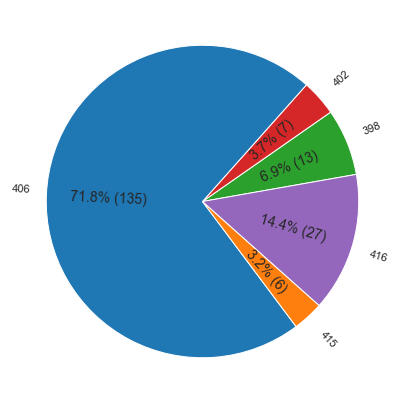

In [78]:
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
plt.figure(figsize=(10,7))
#  = plt.pie(nonzero_spending['Sum'], labels=cat, radius=2, startangle=160,
#                                      autopct=lambda p: f"{p:.2f}%  ({p * sum(nonzero_spending['Sum']) / 100:,.0f})",
#                                      rotatelabels=True, pctdistance=0.5)

patches, labels, pct_texts = plt.pie(counts, labels=unique,  rotatelabels=True, startangle=10, colors=['tab:green','tab:red', 'tab:blue','tab:orange', 'tab:purple'], 
                                     autopct=lambda p: '{:.1f}% ({:.0f})'.format(p,(p/100)*counts.sum()))

for label, pct_text in zip(labels, pct_texts):
    pct_text.set_rotation(label.get_rotation())

In [ ]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')

%matplotlib inline
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(inline_rc)

In [18]:
precision_random = [x['precision'] for x in random_metrics]
# recall_random = [x['recall'] for x in random_metrics]
# accuracy_random = [x['accuracy'] for x in random_metrics]
# f_random = [x['f_score'] for x in random_metrics]

In [ ]:
# Final plots at the other notebook (playground)
plt.hist(precision_random)
precision_max = '{0:.2f}'.format(max(precision_random))
plt.title('scalp: max precision = {}'.format(precision_max))
plt.xlim(0, 1)

Logistic: f1=0.967 auc=0.993
Logistic: f1=0.967 auc=0.999


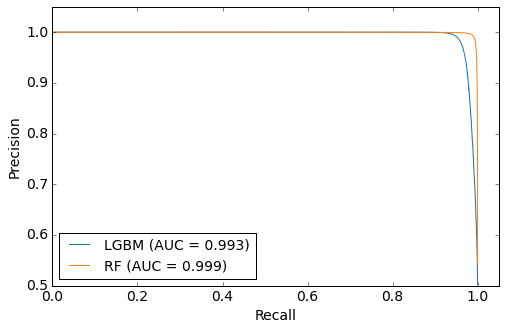

In [38]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
plt.rcParams.update({'font.size': 14, 'font.weight': 'medium'})
plt.figure(figsize=(8,5))
model_lgbm = classifiers_overlap["LGBM"]
model_rf = classifiers_overlap['Random Forest']
testX, testy = X_test_data, y_test
lr_probs = model_lgbm.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, label='LGBM (AUC = 0.993)', color='tab:blue')
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
plt.plot(lr_recall, lr_precision, label='RF (AUC = 0.999)', color='tab:orange')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.gca().set_ylim([0.5, 1.05])
plt.gca().set_xlim([0, 1.05])
# show the legend
plt.legend(loc=3, prop={'size': 14})
# show the plot
plt.show()

In [41]:
testX, testy = X_test_data, y_test
lr_probs = model_rf.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
lr_probs = model_lgbm.predict_proba(testX)[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
lr_f1, lr_auc = f1_score(testy, y_pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.002 auc=0.130
Logistic: f1=0.002 auc=0.112


In [ ]:
# out subject (raw norm)
out_subject = ['398']
y_all_bi_out = get_all_y_multi_channel(subjects=out_subject)
clear_output()
feat_avg_out = get_all_feat_avg_channels(subjects=out_subject)
feat_all_eog2_out = get_all_feat_eog('2', subjects=out_subject)
clear_output()
feat_avg_out.reset_index(inplace=True, drop=True)
feat_all_eog2_out.reset_index(inplace=True, drop=True)
# normalize features?
# feat_eog2_norm = (feat_all_eog2 - feat_all_eog2.mean()) / feat_all_eog2.std()
# feat_eog2_avg = pd.concat([feat_avg_norm, feat_all_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_eog2_avg_out = pd.concat([feat_avg_out, feat_all_eog2_out.iloc[:, 2:].add_suffix('_2')], axis=1)

In [40]:
feat_dict = joblib.load('feat_dict.pkl')
# feat_by_subj = joblib.load('feat_by_subj.pkl')
# joblib.dump(y_by_subj, 'y_by_subj.pkl')
y_dict = joblib.load('y_dict.pkl')

In [ ]:
# all 5 subjects
feat_eog2_avg = pd.concat([feat_dict['396'], feat_dict['398'], feat_dict['406'], feat_dict['415'], feat_dict['416']])
y_all_bi = np.concatenate([y_dict['396'], y_dict['398'], y_dict['406'], y_dict['415'], y_dict['416']])
feat_eog2_avg

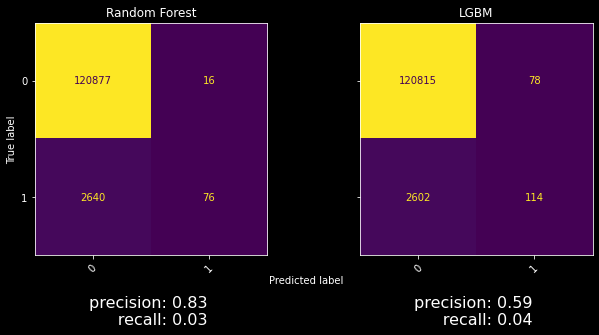

In [37]:
# simple
cls_simple = {
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

f, axes = plt.subplots(1, len(cls_simple), figsize=(10, 5), sharey='row')

# oversample = SMOTE()
# x_over, y_over = oversample.fit_resample(feat_eog2_avg, y_all_bi)
X_train, X_test, y_train, y_test = train_test_split(feat_eog2_avg_5, y_all_bi_5, stratify=y_all_bi_5, random_state=20)
X_train_data = X_train.iloc[:, 2:]
selector = VarianceThreshold(.1)
selector.fit_transform(X_train_data)
X_train_data = X_train_data[X_train_data.columns[selector.get_support(indices=True)]]
X_test_data = X_test[X_train_data.columns]

for i, (key, classifier) in enumerate(cls_simple.items()):
    y_pred = classifier.fit(X_train_data, y_train).predict(X_test_data)
    cf_matrix = confusion_matrix(y_test, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    text = """precision: {0}
              recall: {1}""".format(str('{0:.2f}'.format(metrics['precision'])), str('{0:.2f}'.format(metrics['recall'])))
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')
        y_lgbm = y_pred
    else:
        y_rf = y_pred

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)

plt.show()

ipynb.fs.defs.yasa_model:94: RuntimeWarning: invalid value encountered in double_scalars


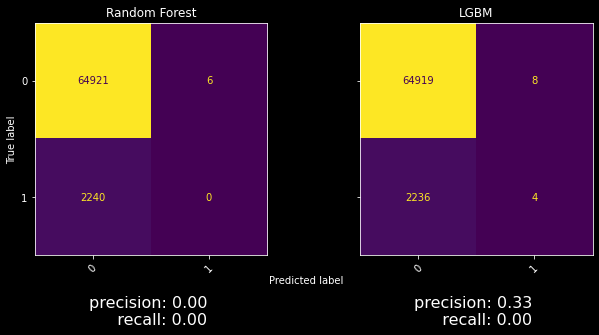

In [38]:
# detection for out subject
f, axes = plt.subplots(1, len(cls_simple), figsize=(10, 5), sharey='row')

feat_396_data = feat_eog2_avg_out.iloc[:, 2:]
feat_396_data = feat_396_data[cls_simple['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_simple.items()):
    y_pred = classifier.predict(feat_396_data)
    cf_matrix = confusion_matrix(y_all_bi_out, y_pred)
    # y_pred = classifier.predict_proba(feat_396_data).T
    # prob = np.sort(y_pred[1])[::-1].T[20]
    # cf_matrix = confusion_matrix(y_396,  [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

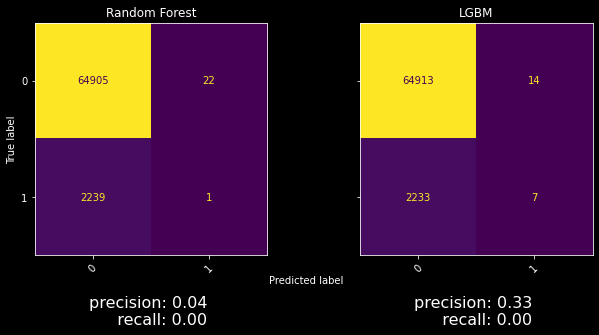

In [39]:
# top 30
f, axes = plt.subplots(1, len(cls_simple), figsize=(10, 5), sharey='row')

feat_396_data = feat_eog2_avg_out.iloc[:, 2:]
feat_396_data = feat_396_data[cls_simple['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls_simple.items()):
    # y_pred = classifier.predict(feat_396_data)
    # cf_matrix = confusion_matrix(y_396_fast, y_pred)
    y_pred = classifier.predict_proba(feat_396_data).T
    prob = np.sort(y_pred[1])[::-1].T[20]
    cf_matrix = confusion_matrix(y_all_bi_out,  [p >= prob for p in y_pred[1]])
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i != 0:
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

In [13]:
# metrics for out subject
y_396_fast = get_all_y_multi_channel(subjects=['398'])
feat_avg_396_fast = get_all_feat_avg_channels(subjects=['398'])
feat_eog2_396_fast = get_all_feat_eog('2', subjects=['398'])
clear_output()
feat_eog2_avg_396_fast = pd.concat([feat_avg_396_fast, feat_eog2_396_fast.iloc[:, 2:].add_suffix('_2')], axis=1)

['avg_dict_16.pkl']

In [92]:
sum = 0
y_AH_dict = {}
for subj in ['426', '429']:
    y_AH = get_all_y_AH(subjects=[subj])
    clear_output()
    y_AH_dict[subj] = y_AH
    sum = sum + y_AH.sum()

joblib.dump(y_AH_dict, 'y_AH_dict_16.pkl')
print(sum)

80188.0


In [94]:
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
y_all_bi = np.concatenate([y_dict[x] for x in all_subject])
y_all_AH.sum()

80188.0

In [7]:
np.concatenate([y_dict[x] for x in all_subject]).sum()

34195.0

In [24]:
y_dict = joblib.load('y_dict_16.pkl')
y_AH_dict = joblib.load('y_AH_dict_16.pkl')
eog1_dict = joblib.load('eog1_dict_16.pkl')
eog2_dict = joblib.load('eog2_dict_16.pkl')
avg_dict = joblib.load('avg_dict_16.pkl')

In [96]:
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
y_all_bi = np.concatenate([y_dict[x] for x in all_subject])
y_all_AH = np.concatenate([y_AH_dict[x] for x in all_subject])
feat_eog2 = pd.concat([eog2_dict[x] for x in all_subject])
feat_eog1 = pd.concat([eog1_dict[x] for x in all_subject])
feat_avg = pd.concat([avg_dict[x] for x in all_subject])
feat_eog1_avg = pd.concat([feat_eog1, feat_avg.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_eog2_avg = pd.concat([feat_eog2, feat_avg.iloc[:, 2:].add_suffix('_2')], axis=1)
feat_eog12 = pd.concat([feat_eog1, feat_eog2.iloc[:, 2:].add_suffix('_2')], axis=1)

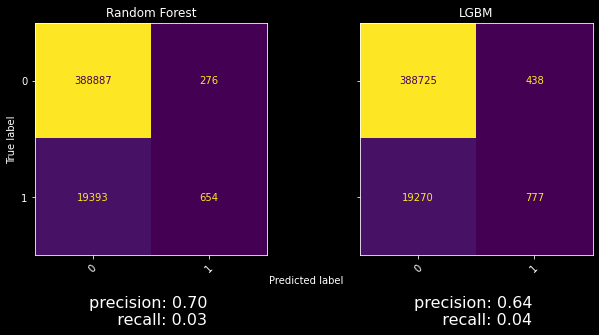

In [15]:
# plot all 16 subj with their best features, y_AH
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
y_all_bi = np.concatenate([y_AH_dict[x] for x in all_subject])
feat_all = pd.DataFrame()
for subj in all_subject:
    if subj in subj_eog1:
        curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    elif subj in subj_eog2:
        curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    else:
        curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
    feat_all = pd.concat([feat_all, curr_feat])

cls, pred_details = plt_cls(feat_all, y_all_bi)

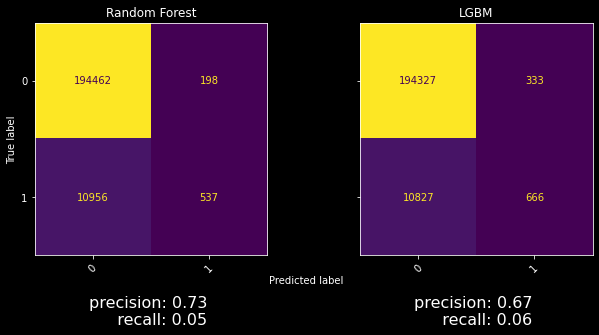

In [13]:
# try only good subj
all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x not in subj_bad])
for subj in all_subject:
    if subj not in subj_bad:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

cls, pred_details = plt_cls(feat_all_good, y_all_good)

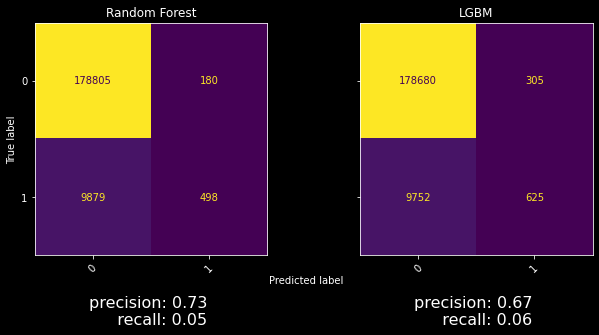

In [33]:
# generalization: try only good subj
good_subj = [x for x in all_subject if x not in subj_bad]
out_subj = good_subj[1]
# out_subj = '414'
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_AH_dict[x] for x in good_subj if x != out_subj])
for subj in good_subj:
    if subj != out_subj:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

cls, pred_details = plt_cls(feat_all_good, y_all_good)

In [34]:
good_subj

['38', '398', '402', '404', '406', '414', '415', '416']

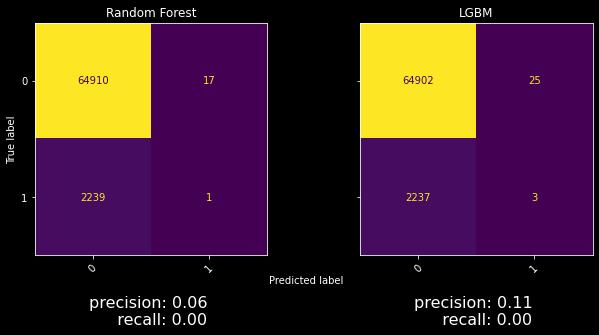

In [35]:
# out subject
y_out = y_dict[out_subj]
if out_subj in subj_eog1:
    feat_out = pd.concat([eog1_dict[out_subj], avg_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)
elif out_subj in subj_eog2:
    feat_out = pd.concat([eog2_dict[out_subj], avg_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)
else:
    feat_out = pd.concat([eog1_dict[out_subj], eog2_dict[out_subj].iloc[:, 2:].add_suffix('_2')], axis=1)
f, axes = plt.subplots(1, len(cls), figsize=(10, 5), sharey='row')

feat_out_data = feat_out.iloc[:, 2:]
feat_out_data = feat_out_data[cls['LGBM'].feature_name_]

for i, (key, classifier) in enumerate(cls.items()):
    y_pred = classifier.predict(feat_out_data)
    cf_matrix = confusion_matrix(y_out, y_pred)
    metrics = get_metrics(cf_matrix)
    disp = ConfusionMatrixDisplay(cf_matrix)
    disp.plot(ax=axes[i], xticks_rotation=45)
    precision = '{0:.2f}'.format(metrics['precision'])
    recall = '{0:.2f}'.format(metrics['recall'])
    text = """precision: {0}
                  recall: {1}""".format(precision, recall)
    axes[i].annotate(text, xy=(1, 0), xycoords='axes fraction', fontsize=16,
                     xytext=(-60, -40), textcoords='offset points',
                     ha='right', va='top')
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i == 0:
        y_rf = y_pred
    else:
        y_lgbm = y_pred
        disp.ax_.set_ylabel('')

f.text(0.45, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)
plt.show()

[Text(0.4789496527777778, 0.9444444444444444, 'X[11] <= 0.025\ngini = 0.5\nsamples = 471668\nvalue = [373612, 372573]'),
 Text(0.2199074074074074, 0.8333333333333334, 'X[21] <= -0.121\ngini = 0.455\nsamples = 85277\nvalue = [87752, 47175]'),
 Text(0.1072048611111111, 0.7222222222222222, 'X[20] <= -0.168\ngini = 0.354\nsamples = 15526\nvalue = [18864, 5620]'),
 Text(0.046296296296296294, 0.6111111111111112, 'X[36] <= 4192.171\ngini = 0.48\nsamples = 1847\nvalue = [1758, 1169]'),
 Text(0.018518518518518517, 0.5, 'X[35] <= 0.0\ngini = 0.238\nsamples = 354\nvalue = [475, 76]'),
 Text(0.006944444444444444, 0.3888888888888889, 'X[11] <= 0.009\ngini = 0.398\nsamples = 114\nvalue = [127, 48]'),
 Text(0.004629629629629629, 0.2777777777777778, 'gini = 0.0\nsamples = 20\nvalue = [35, 0]'),
 Text(0.009259259259259259, 0.2777777777777778, 'X[14] <= 2.347\ngini = 0.451\nsamples = 94\nvalue = [92, 48]'),
 Text(0.004629629629629629, 0.16666666666666666, 'X[36] <= 3324.154\ngini = 0.358\nsamples = 71\n

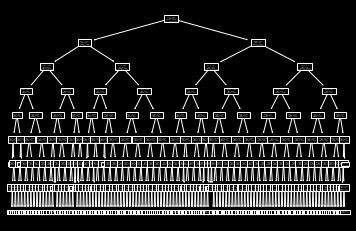

In [39]:
from sklearn.tree import plot_tree

plot_tree(cls_all_balance["Random Forest"].estimators_[0])

In [42]:
pd.DataFrame(data={'396':feat_dict['396'].mean(), '398':feat_dict['398'].mean(), '402':feat_dict['402'].mean(), '406':feat_dict['406'].mean(), '415':feat_dict['415'].mean(), '416':feat_dict['416'].mean()})

,396,398,402,406,415,416
subj,inf,inf,inf,inf,inf,inf
epoch_id,4.9905000000e+04,3.3583000000e+04,4.6505000000e+04,4.3615000000e+04,5.3585000000e+04,5.3605000000e+04
std,2.9836602625e-01,3.2703492598e-01,3.6776350523e-01,4.1857320070e-01,3.2603509009e-01,3.8549678160e-01
iqr,4.6374493286e-01,5.2130531275e-01,5.8460756230e-01,6.2155522808e-01,4.9046016752e-01,6.1009054100e-01
skew,1.2328908126e-02,2.4590377812e-02,2.5831569506e-02,-9.4802723232e-03,-2.9001764016e-03,-2.9138367635e-02
...,...,...,...,...,...,...
gf_pmin_norm_2,2.1409936182e-01,1.8005312820e-01,2.6931136026e-01,1.5745012861e-01,1.7969931040e-01,1.9187210836e-01
abspow_pmin_norm_2,1.4163010914e-01,1.3581834385e-01,1.2287783666e-01,1.2639219936e-01,1.4601850653e-01,1.6157700231e-01
perm_pmin_norm_2,-1.2950833977e-02,1.9227583121e-02,-5.2907848306e-03,2.8304750275e-02,-8.9487395427e-03,-2.1062595859e-02
higuchi_pmin_norm_2,4.1907412589e-02,2.8881208776e-02,5.1632490501e-02,3.4396358302e-02,3.7204909848e-02,3.5349296455e-02


In [43]:
pd.DataFrame(data={'396':feat_dict['396'].std(), '398':feat_dict['398'].std(), '402':feat_dict['402'].std(), '406':feat_dict['406'].std(), '415':feat_dict['415'].std(), '416':feat_dict['416'].std()})

,396,398,402,406,415,416
epoch_id,28813.0981962486,19389.5871023599,26850.1072809775,25181.5650029938,30937.7471868913,30949.2941922752
std,0.2370681153,0.2252704903,0.2215162260,0.1954893331,0.2841393580,0.3420795836
iqr,0.4313076195,0.4216272795,0.4198838567,0.3504548653,0.4980464195,0.6026087793
skew,0.5398555171,0.5465167877,0.5601110129,0.5179089686,0.5375886450,0.5596389369
kurt,0.9463077832,0.8101895434,0.8230975674,0.7998405118,1.0351816196,0.7947198190
...,...,...,...,...,...,...
gf_pmin_norm_2,1.7603369492,0.7689358166,5.8325358785,0.6424000924,1.4402726815,1.4399323416
abspow_pmin_norm_2,0.4986857827,0.5118409289,0.5347482949,0.5258687383,0.4393497064,0.6149172798
perm_pmin_norm_2,0.3116949585,0.3107194392,0.3133313371,0.3156495608,0.3206858839,0.3086517368
higuchi_pmin_norm_2,0.3402080111,0.3223836276,0.3485749767,0.3454663614,0.3291536005,0.3319506946


In [3]:
# save_features_dicts(file_name='before_split', detection_func='AH+bi')
y_dict = joblib.load('y_dict_before_split_AH+bi.pkl')
eog1_dict = joblib.load('eog1_dict_before_split.pkl')
eog2_dict = joblib.load('eog2_dict_before_split.pkl')
avg_dict = joblib.load('avg_dict_before_split.pkl')

In [3]:
# try only good subj
# all_subject = ['38', '394', '396', '398', '400', '402', '404', '405', '406', '414', '415', '416', '417', '423', '426', '429']
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_dict[x] for x in all_subject if x not in subj_bad])
for subj in all_subject:
    if subj not in subj_bad:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)

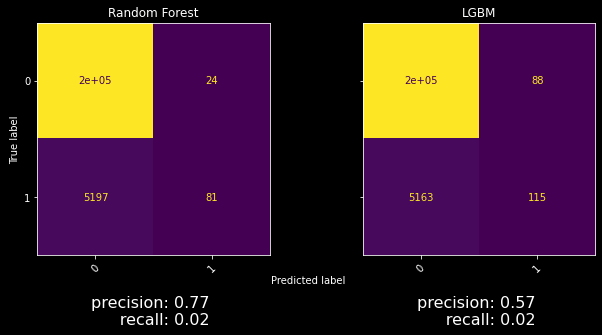

In [6]:
cls, pred_details = plot_results(X_train, X_test, y_train, y_test)

In [2]:
y_dict = {}
for subj in all_subject:
    y_396_fast = get_all_y_AH(subjects=[subj], bi=True)
    clear_output()
    y_dict[subj] = y_396_fast

joblib.dump(y_dict, f'y_dict_bi_only.pkl')
np.concatenate([y_dict[x] for x in all_subject]).sum()

30107.0

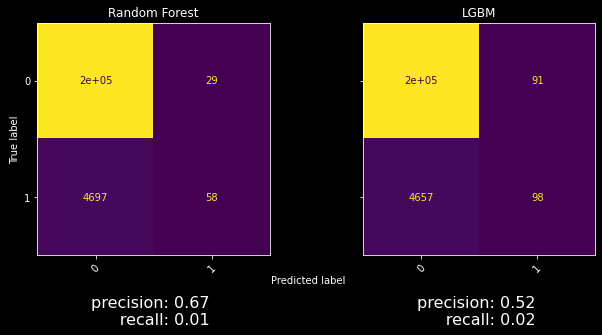

In [4]:
y_dict = joblib.load('y_dict_bi_only.pkl')
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_dict[x] for x in all_subject if x not in subj_bad])
for subj in all_subject:
    if subj not in subj_bad:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)
cls, pred_details = plot_results(X_train, X_test, y_train, y_test)

In [ ]:
y_dict = joblib.load('y_dict_bi_only.pkl')
feat_all_good = pd.DataFrame()
y_all_good = np.concatenate([y_dict[x] for x in all_subject if x not in subj_bad])
for subj in all_subject:
    if subj not in subj_bad:
        if subj in subj_eog1:
            curr_feat = pd.concat([eog1_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        elif subj in subj_eog2:
            curr_feat = pd.concat([eog2_dict[subj], avg_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        else:
            curr_feat = pd.concat([eog1_dict[subj], eog2_dict[subj].iloc[:, 2:].add_suffix('_2')], axis=1)
        feat_all_good = pd.concat([feat_all_good, curr_feat])

X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)
cls, pred_details = plot_results(X_train, X_test, y_train, y_test)

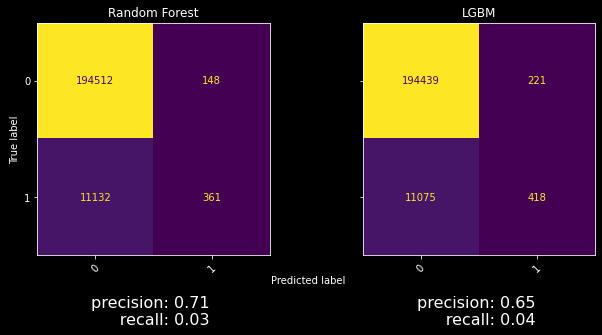

In [6]:
y_AH_dict = joblib.load('results/y_AH_dict_16.pkl')
y_all_good = np.concatenate([y_AH_dict[x] for x in all_subject if x not in subj_bad])
X_train, X_test, y_train, y_test = train_test_split(feat_all_good, y_all_good, stratify=y_all_good, random_state=20)

# Add separated norm values
X_train_after = calc_features_after_split(X_train)
X_test_after = calc_features_after_split(X_test)
cls, pred_details = plot_results(X_train, X_test, y_train, y_test)